# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

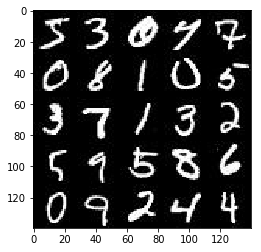

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

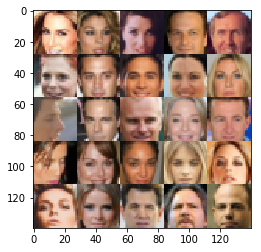

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='lr')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [48]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        #print(conv1.get_shape().as_list())
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #print(conv2.get_shape().as_list())
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #print(conv3.get_shape().as_list())
        
        conv4 = tf.layers.conv2d(conv3, 512, 5, 1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha * conv4, conv4)
        #print(conv4.get_shape().as_list())
        
        dimensions = conv4.get_shape().as_list()
        flatten = tf.reshape(conv4, (-1, dimensions[1]*dimensions[2]*dimensions[3]))
        logits = tf.layers.dense(flatten, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [49]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        dense = tf.layers.dense(z, 2*2*1024)
        dense = tf.reshape(dense, (-1, 2, 2, 1024))
        dense_norm = tf.layers.batch_normalization(dense, training=is_train)
        dense_relu = tf.maximum(alpha * dense_norm, dense_norm)
        #dense_relu = tf.nn.relu(dense_norm)
        
        #print(dense_relu.get_shape().as_list())
        conv1 = tf.layers.conv2d_transpose(dense_relu, 512, 5, 2, padding='SAME')
        #print(conv1.get_shape().as_list())
        conv1_norm = tf.layers.batch_normalization(conv1, training=is_train)
        conv1_relu = tf.maximum(alpha * conv1_norm, conv1_norm)
        #conv1_relu = tf.nn.relu(conv1_norm)
        
        #print(conv1_relu.get_shape().as_list())
        conv2 = tf.layers.conv2d_transpose(conv1_relu, 256, 4, 1, padding='VALID')
        #print(conv2.get_shape().as_list())
        conv2_norm = tf.layers.batch_normalization(conv2, training=is_train)
        conv2_relu = tf.maximum(alpha * conv2_norm, conv2_norm)
        #conv1_relu = tf.nn.relu(conv1_norm)
        
        #print(conv2_relu.get_shape().as_list())
        conv3 = tf.layers.conv2d_transpose(conv2_relu, 128, 5, 2, padding='SAME')
        #print(conv3.get_shape().as_list())
        conv3_norm = tf.layers.batch_normalization(conv3, training=is_train)
        conv3_relu = tf.maximum(alpha * conv3_norm, conv3_norm)
        #conv2_relu = tf.nn.relu(conv2_norm)
        
        
        #print(conv3_relu.get_shape().as_list())
        conv4 = tf.layers.conv2d_transpose(conv3_relu, out_channel_dim, 5, 2, padding='SAME')
        #print(conv4.get_shape().as_list())
        output = tf.nn.tanh(conv4)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [50]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Perform label smoothing as advised here: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    real_label_dim = d_model_real.get_shape().as_list()[1]
    real_labels_smoothed = tf.random_uniform([real_label_dim], 0.7, 1.2)
    real_labels_smoothed = tf.reshape(real_labels_smoothed, (-1, real_label_dim))
    
    fake_label_dim = d_model_fake.get_shape().as_list()[1]
    fake_labels_smoothed = tf.random_uniform([fake_label_dim], 0, 0.3)
    fake_labels_smoothed = tf.reshape(fake_labels_smoothed, (-1, fake_label_dim))
    fake_labels_smoothed_ones = tf.random_uniform([fake_label_dim], 0.7, 1.2)
    fake_labels_smoothed_ones = tf.reshape(fake_labels_smoothed_ones, (-1, fake_label_dim))
    
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                        labels=real_labels_smoothed))
                                                        #labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                        labels=fake_labels_smoothed))
                                                        #labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                        labels=fake_labels_smoothed_ones))
                                                        #labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [51]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [53]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                num_gen = 1
                batch_z = np.random.uniform(-1, 1, size=(num_gen, batch_size, z_dim))
                
                #normalize images from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images * 2
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z[0]})
                for i in range(num_gen):
                    sess.run(g_train_opt, feed_dict={z_input: batch_z[i], real_input: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z[0], real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z[0]})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps%100 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3949... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 2.2770
Epoch 1/2... Discriminator Loss: 7.3906... Generator Loss: 10.0072
Epoch 1/2... Discriminator Loss: 2.0559... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 3.2141... Generator Loss: 5.5830
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 0.3778
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 3.3453
Epoch 1/2... Discriminator Loss: 2.9008... Generator Loss: 5.1395
Epoch 1/2... Discriminator Loss: 1.8332... Generator Loss: 4.6440
Epoch 1/2... Discriminator Loss: 2.2539... Generator Loss: 0.1093


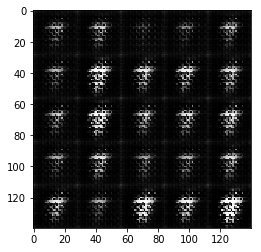

Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 1.3402
Epoch 1/2... Discriminator Loss: 3.4433... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 2.4764... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.9149
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.9980
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.1922
Epoch 1/2... Discriminator Loss: 1.9368... Generator Loss: -0.0260
Epoch 1/2... Discriminator Loss: -0.1024... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 0.6089


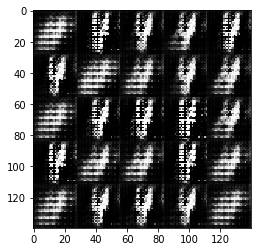

Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.1318
Epoch 1/2... Discriminator Loss: 3.8776... Generator Loss: 5.9859
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 0.1005... Generator Loss: 1.8671
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 1.7876
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 2.7128
Epoch 1/2... Discriminator Loss: 2.5547... Generator Loss: 3.9739
Epoch 1/2... Discriminator Loss: 1.6116... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 2.9498


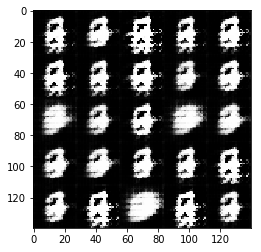

Epoch 1/2... Discriminator Loss: 2.5616... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 3.0471... Generator Loss: 4.6829
Epoch 1/2... Discriminator Loss: 1.9995... Generator Loss: 3.1578
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 0.5337
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 1.9580
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.5842
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 2.7182


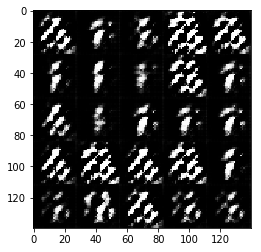

Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.3006
Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.9365... Generator Loss: -0.2178
Epoch 1/2... Discriminator Loss: 1.6565... Generator Loss: 1.3741
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 1.5315
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 0.9506
Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 0.3198
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 0.5059


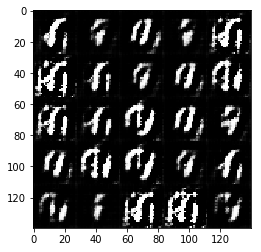

Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.5588
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 1.4236
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.5496
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 2.0508
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 1.8538... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 1.2977


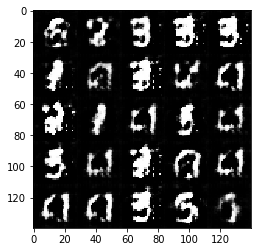

Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 0.3450
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 1.5032... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 1.6263... Generator Loss: 3.0397
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.0147
Epoch 1/2... Discriminator Loss: 1.6129... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 1.9238
Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 1.0858


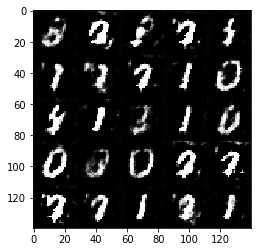

Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 1.6292
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.0940
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 1.7114
Epoch 1/2... Discriminator Loss: 1.9465... Generator Loss: 0.3650
Epoch 1/2... Discriminator Loss: 0.4071... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 0.3836


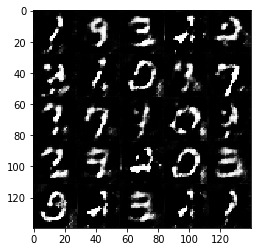

Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 2.4580... Generator Loss: -0.2712
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.7481
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 0.7528


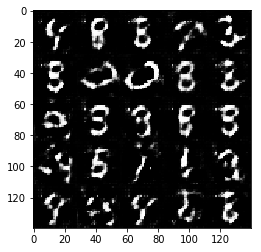

Epoch 1/2... Discriminator Loss: 0.7792... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 2.5313... Generator Loss: -0.1322
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.6006
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.6625... Generator Loss: 2.3139
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.3811


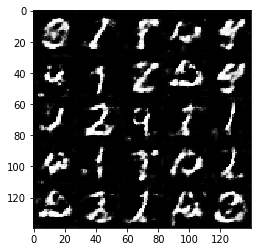

Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.7872
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.3753
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 0.9052
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 0.7015


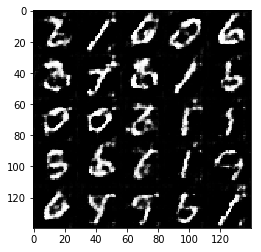

Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.9163... Generator Loss: 0.1843
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.1300
Epoch 1/2... Discriminator Loss: 1.4744... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 3.2858... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 0.6105
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 2.2330
Epoch 1/2... Discriminator Loss: 2.0374... Generator Loss: 0.5890


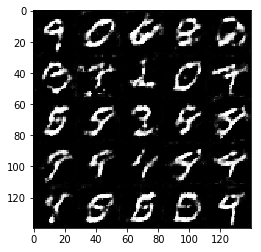

Epoch 1/2... Discriminator Loss: 1.9659... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.0201
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.6487... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 0.6172


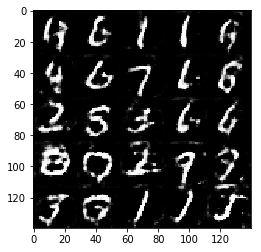

Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.2627
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 1.6111... Generator Loss: 1.9872
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 1.8326... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 0.8016


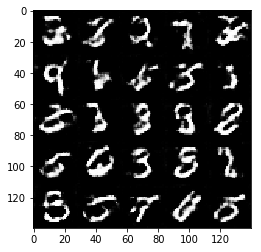

Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 1.3903
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.4841... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.4145
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.2693
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.8540


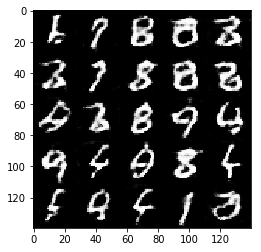

Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.5762
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 1.0760
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 1.7905... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 0.9848... Generator Loss: 0.6784


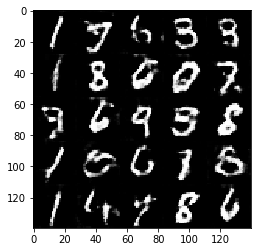

Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 1.5250
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 2.0796... Generator Loss: 0.2670
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.8624
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.3520


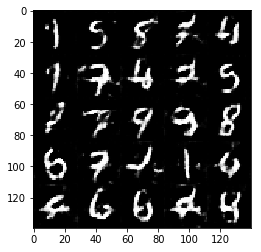

Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 3.1599
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.1150
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 2.0921... Generator Loss: 0.3794
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 1.8007... Generator Loss: 1.9974
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 0.6126... Generator Loss: 0.8711


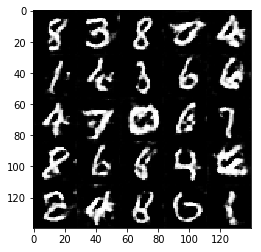

Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 2.0882... Generator Loss: 0.2602
Epoch 1/2... Discriminator Loss: 1.8480... Generator Loss: 0.1287
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 1.5295
Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 0.6019


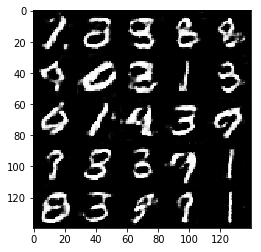

Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 1.1367
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.9723
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.2017
Epoch 2/2... Discriminator Loss: 0.4698... Generator Loss: 0.9927
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 0.7505


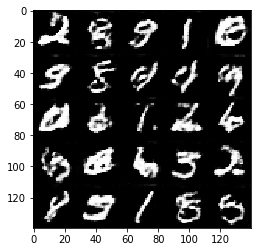

Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 1.8312
Epoch 2/2... Discriminator Loss: 1.9176... Generator Loss: 0.4627
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 1.3728
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.1504
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 1.5964... Generator Loss: 0.4813


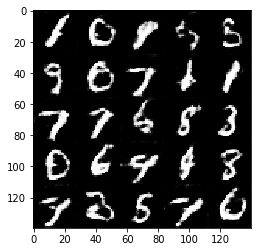

Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 1.5875... Generator Loss: 0.2634
Epoch 2/2... Discriminator Loss: 1.9631... Generator Loss: 2.2883
Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: -0.0554
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 2.3989
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 1.7241... Generator Loss: 0.1776
Epoch 2/2... Discriminator Loss: 1.1351... Generator Loss: 0.3293
Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 3.8088
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 1.4064


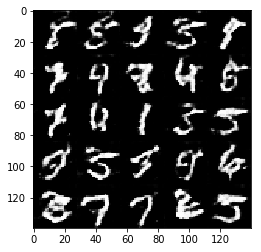

Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 1.6428... Generator Loss: 1.5024
Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 1.9769
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 2.9347
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 2.2068... Generator Loss: 0.4750
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 1.5184... Generator Loss: 2.3998
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 0.0100


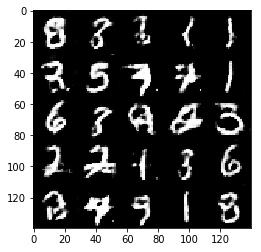

Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 1.8375... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.4016
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 2.1079... Generator Loss: 2.1382
Epoch 2/2... Discriminator Loss: 1.8721... Generator Loss: 1.8353
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.2505
Epoch 2/2... Discriminator Loss: 1.7870... Generator Loss: 0.3534


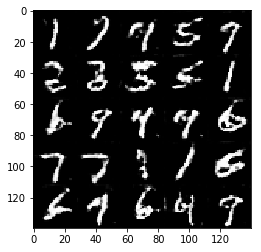

Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.6910
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 2.1228
Epoch 2/2... Discriminator Loss: 2.2038... Generator Loss: 0.1572
Epoch 2/2... Discriminator Loss: 2.0581... Generator Loss: 3.0213
Epoch 2/2... Discriminator Loss: 1.8428... Generator Loss: 0.2317
Epoch 2/2... Discriminator Loss: 2.0890... Generator Loss: 0.2535


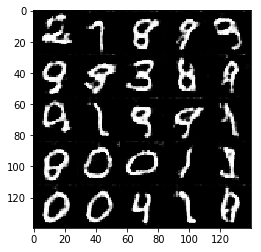

Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 1.2807... Generator Loss: 0.3740
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 2.3590... Generator Loss: 3.7469
Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 1.2924


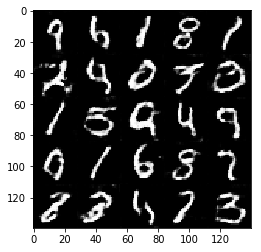

Epoch 2/2... Discriminator Loss: 1.9289... Generator Loss: 0.5495
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 2.1242
Epoch 2/2... Discriminator Loss: 2.1743... Generator Loss: 2.1374
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.6070
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.6732
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 1.3921
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.8807
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 1.8331... Generator Loss: 0.3964


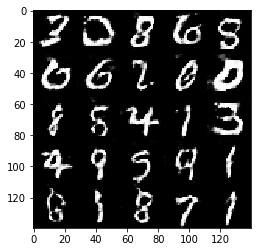

Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.1265
Epoch 2/2... Discriminator Loss: 1.5769... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.3730
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.1700
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.7135


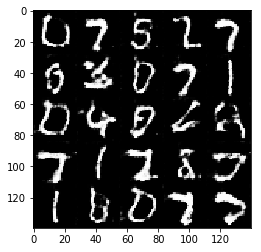

Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.9924... Generator Loss: 0.1081
Epoch 2/2... Discriminator Loss: 1.6011... Generator Loss: 1.8087
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.7138
Epoch 2/2... Discriminator Loss: 1.8545... Generator Loss: 0.6103
Epoch 2/2... Discriminator Loss: 0.4497... Generator Loss: 1.8646
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.5941


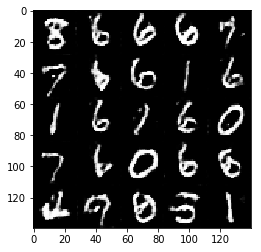

Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 2.1015... Generator Loss: 0.5535
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 0.1544
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 1.3458


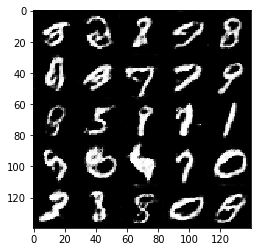

Epoch 2/2... Discriminator Loss: 0.7511... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 1.4622... Generator Loss: 0.3715
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 2.4856... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.5932... Generator Loss: 1.2895
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.5911


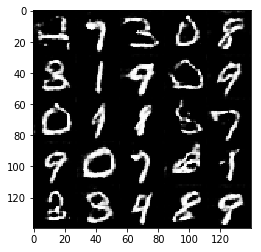

Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 1.3801
Epoch 2/2... Discriminator Loss: 2.2225... Generator Loss: 2.6413
Epoch 2/2... Discriminator Loss: 2.1340... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 1.5902
Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 1.8233... Generator Loss: 0.4489
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.9871
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.9887
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.0320


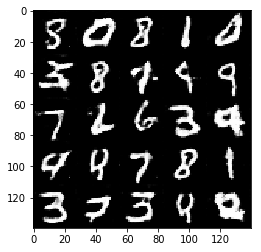

Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.0118
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.2829
Epoch 2/2... Discriminator Loss: 0.4495... Generator Loss: 0.1299
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 2.1865... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.6691... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 2.3898... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 1.6603... Generator Loss: 0.6129
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.4013


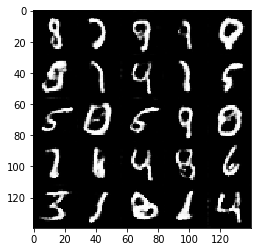

Epoch 2/2... Discriminator Loss: 1.7996... Generator Loss: 2.9149
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.7645... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 1.1042
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 1.3078
Epoch 2/2... Discriminator Loss: 1.6400... Generator Loss: 0.1229
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 2.1968... Generator Loss: 0.1696


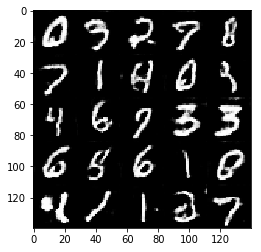

Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.5014... Generator Loss: 1.3318
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 0.4169
Epoch 2/2... Discriminator Loss: 1.6136... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.5771... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.4504... Generator Loss: 0.9512


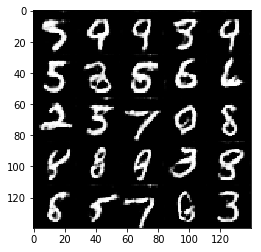

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.8247... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 1.6706
Epoch 2/2... Discriminator Loss: 1.9233... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 0.1986
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 2.7442... Generator Loss: 0.0631
Epoch 2/2... Discriminator Loss: 3.5917... Generator Loss: -0.2623
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 0.5362


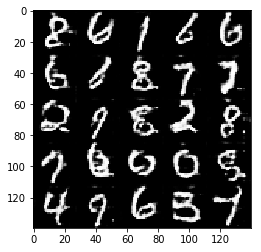

Epoch 2/2... Discriminator Loss: 0.4480... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 0.4366
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 1.6176
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: -0.1610
Epoch 2/2... Discriminator Loss: 1.6784... Generator Loss: 0.3130
Epoch 2/2... Discriminator Loss: 1.5986... Generator Loss: 0.4151
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 1.7240... Generator Loss: 0.6392


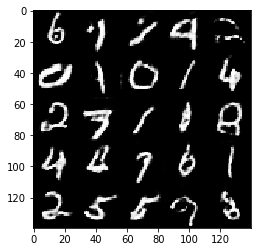

Epoch 2/2... Discriminator Loss: 1.7925... Generator Loss: 0.5317
Epoch 2/2... Discriminator Loss: 1.6439... Generator Loss: 0.3046
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.3068
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 1.1020
Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 0.9047


In [54]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8631... Generator Loss: 17.0192
Epoch 1/1... Discriminator Loss: 3.9653... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.9717
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 3.8756
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 2.1315... Generator Loss: 6.1320
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 0.2988


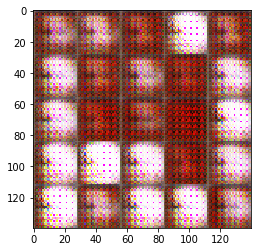

Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.9489... Generator Loss: 3.6386
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.4898


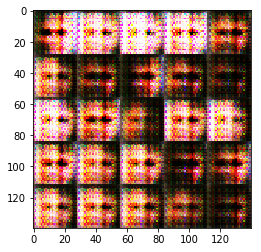

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6032


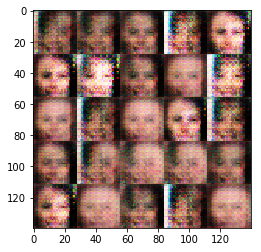

Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.8171... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0562


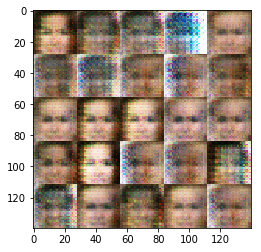

Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.6588... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 2.2362... Generator Loss: 1.6967
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.3191


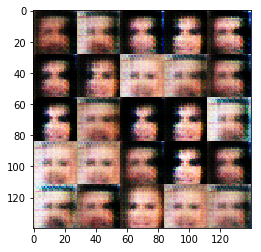

Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.7399... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.2352... Generator Loss: 0.6897


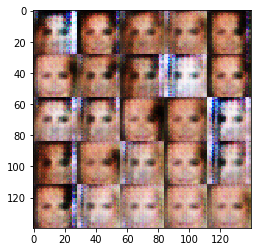

Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.0094


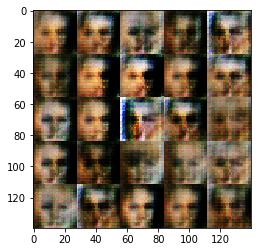

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.5554... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.1577


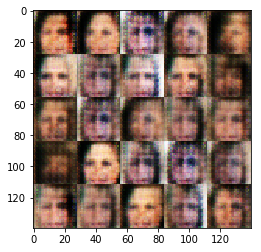

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.2873
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.2319
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8858


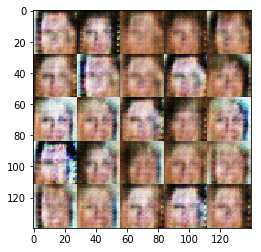

Epoch 1/1... Discriminator Loss: 2.1551... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7072


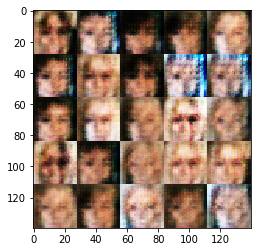

Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 2.3333
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.9682... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 1.6928... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.2262
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.4627


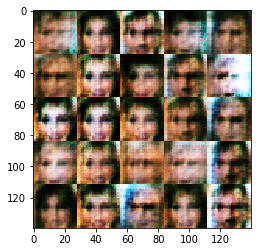

Epoch 1/1... Discriminator Loss: 1.7438... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 1.1054


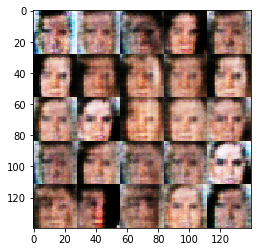

Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.6103... Generator Loss: 2.3470
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9561


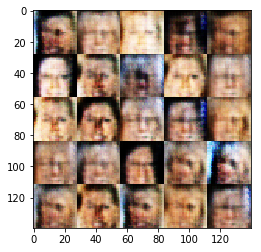

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 1.6944... Generator Loss: 1.6498
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 1.3925
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6632


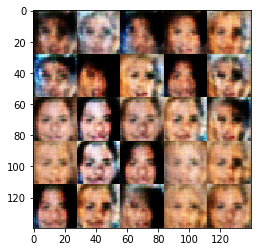

Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 1.9303
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 2.0194... Generator Loss: 0.4115


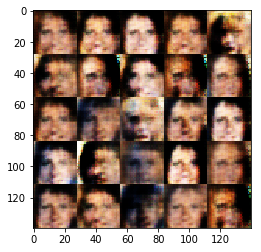

Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.6351
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 2.7488... Generator Loss: 0.2591
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.8617


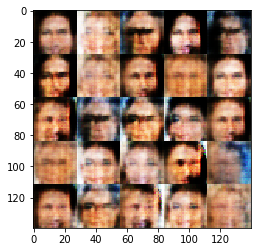

Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 2.3492
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.6592


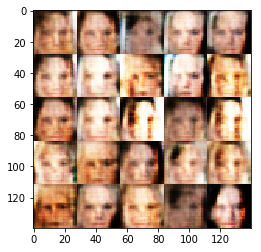

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.1826... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 0.8151


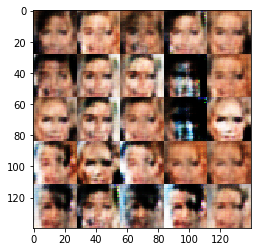

Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.6496
Epoch 1/1... Discriminator Loss: 0.1472... Generator Loss: 0.1350
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.8302


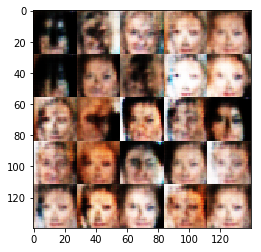

Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.3436


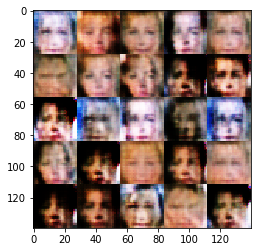

Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 1.9453
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 2.8107
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.6598
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 0.9962


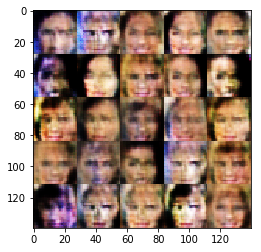

Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.4537


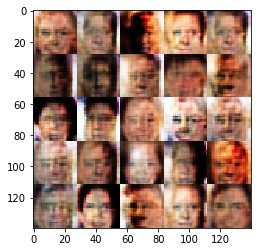

Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: -0.0690
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.1637
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.0905
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 2.1474... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 1.1595


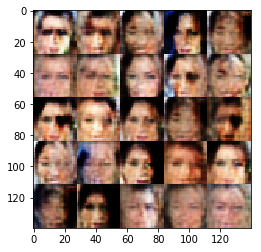

Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.2899
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.4354
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 0.9071


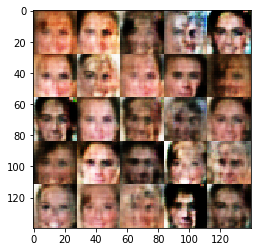

Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.4857
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 0.1690
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 2.1586
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.2705
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.5716


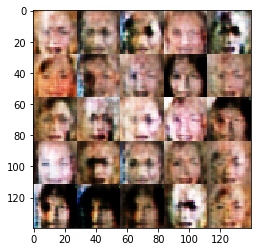

Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 2.3856
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.2602
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 2.4538... Generator Loss: -0.0688
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 5.8423... Generator Loss: 2.3808


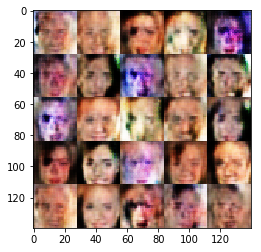

Epoch 1/1... Discriminator Loss: 2.1283... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 2.1655... Generator Loss: 0.1527
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.8452
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.1076


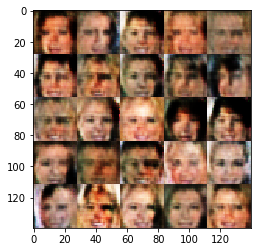

Epoch 1/1... Discriminator Loss: 1.9489... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 0.2785... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 3.0757... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 2.6956
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.4340


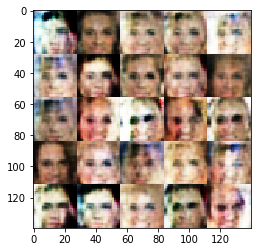

Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.7051
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 2.1127... Generator Loss: 0.2941


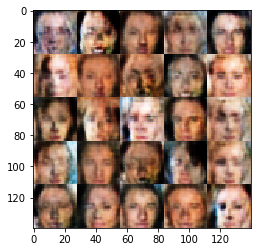

Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.9556
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 2.3410
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 2.0804
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 2.0907


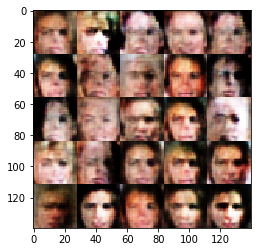

Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.3101
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 1.7362
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 1.0531


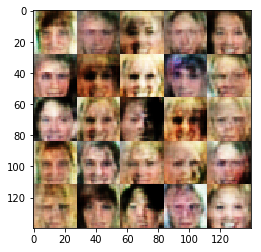

Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.4073
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.5371
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 2.8491
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 1.0943


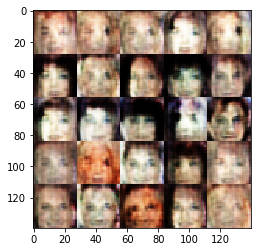

Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.6825
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.2376
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.7362


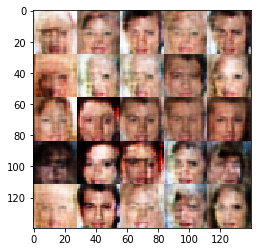

Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.8472... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 2.8123... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.0917


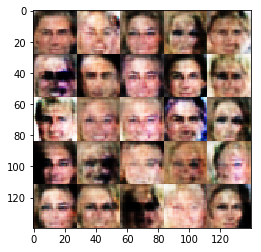

Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.6052
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 2.0091


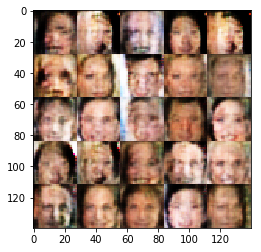

Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 2.2284
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 1.9403
Epoch 1/1... Discriminator Loss: 2.0840... Generator Loss: 0.1569
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 2.2071
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.6646


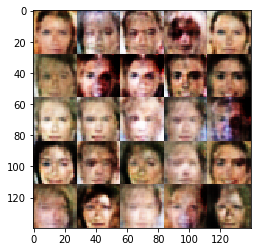

Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 2.9415
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 1.9102... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.1108


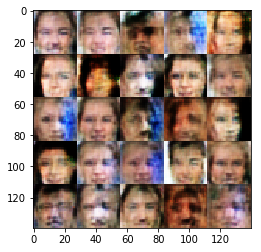

Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.3169... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: -0.1341... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.7811
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.5374


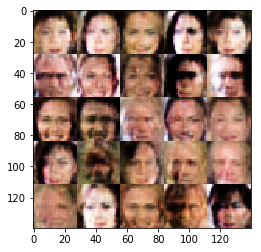

Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.3584
Epoch 1/1... Discriminator Loss: 1.9489... Generator Loss: -0.1288
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.4144
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9306


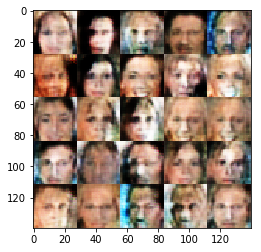

Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.7521... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.9190
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 0.8069


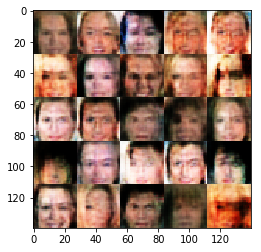

Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 2.2407... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.7959


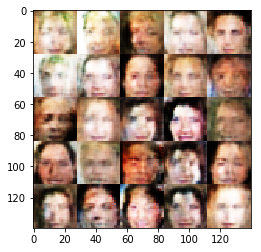

Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.6369
Epoch 1/1... Discriminator Loss: -0.0300... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.2442
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.4426


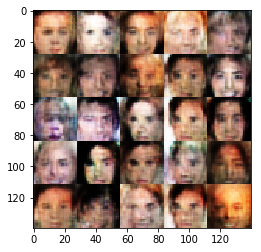

Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 0.1155... Generator Loss: 0.7463


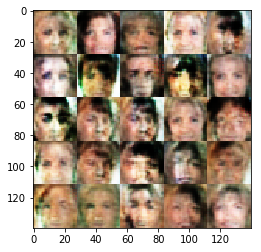

Epoch 1/1... Discriminator Loss: 1.9295... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.6248
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 3.3227
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 2.3612... Generator Loss: 0.0661
Epoch 1/1... Discriminator Loss: 0.6015... Generator Loss: 1.3873


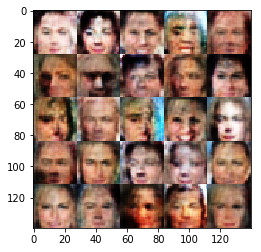

Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 2.5345
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: -0.0015
Epoch 1/1... Discriminator Loss: 0.2445... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 2.4032
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 1.2099


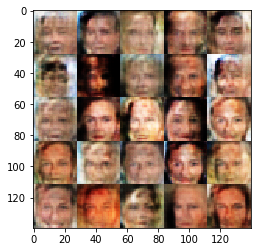

Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 2.0939
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 2.0871
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.5940
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.3883


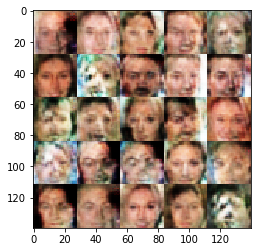

Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 3.0659
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.1888


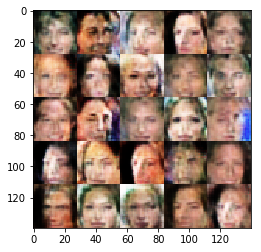

Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 2.3264
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.6057
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.6093
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.7145


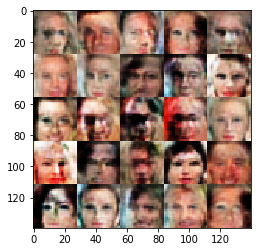

Epoch 1/1... Discriminator Loss: -0.4341... Generator Loss: 1.8983
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 1.9587
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 1.8632
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.9774
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 2.5474


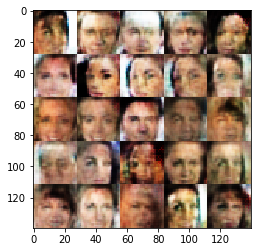

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 1.4034
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.7502
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 2.0790
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 1.6472
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 2.3285


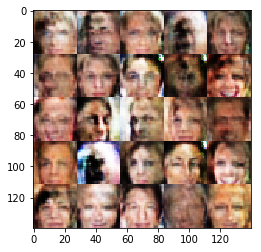

Epoch 1/1... Discriminator Loss: 2.0890... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 2.4780... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.5932
Epoch 1/1... Discriminator Loss: -0.5575... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.0252
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.5870


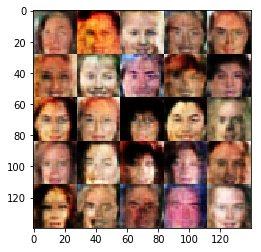

Epoch 1/1... Discriminator Loss: -0.3430... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.2286
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.5464
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.4963


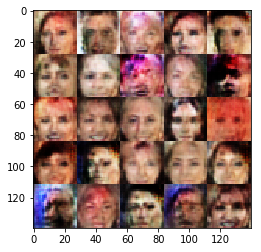

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 0.1790... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.7937... Generator Loss: 3.1695
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 2.1130
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.8455


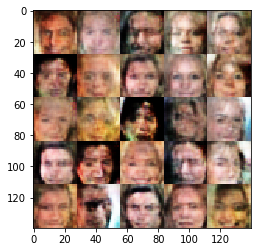

Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.2586... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 0.1520... Generator Loss: 1.9870
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 1.5868
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 2.0339
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 2.0033


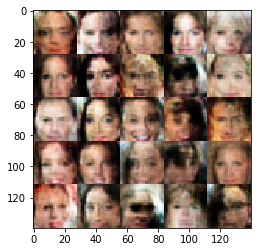

Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.6266
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.4165


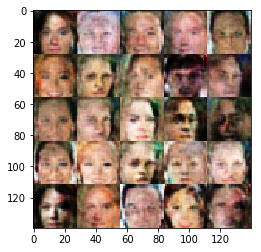

Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 1.6343
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 0.0797... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.6844
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 2.2647
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 1.0285


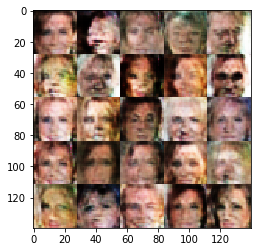

Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.8668
Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 2.7767... Generator Loss: -0.1436
Epoch 1/1... Discriminator Loss: -0.0466... Generator Loss: 1.9094
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8854


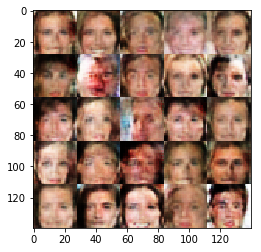

Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 0.3074... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 2.0066
Epoch 1/1... Discriminator Loss: 2.4090... Generator Loss: 0.3593
Epoch 1/1... Discriminator Loss: -0.0189... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.8564... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.3697


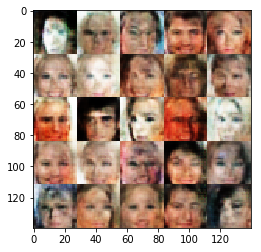

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 0.7408


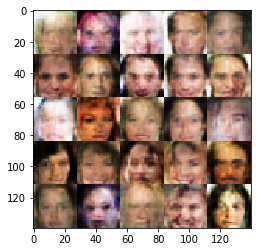

Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.8130
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 2.0243
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 3.0000
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9200


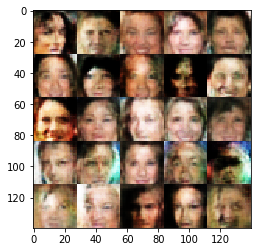

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 2.3774
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 1.4255


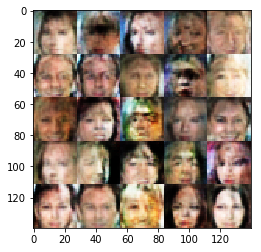

Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.3610
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.9306
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.8468
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 2.7998
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.4555


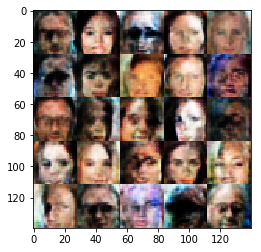

Epoch 1/1... Discriminator Loss: 0.3104... Generator Loss: 1.9177
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 1.6210
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: -0.5086... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 2.5139
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.6886
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.6630


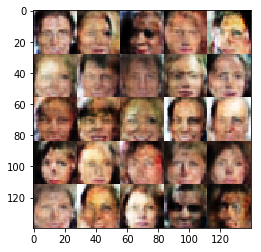

Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 2.3657
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 1.9607


In [55]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.